# SVM Classifier

In [204]:
import pandas as pd
import numpy as np
from astropy.table import Table, vstack
from astroquery.gaia import Gaia
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import os
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

### Gaia data retrieval

In [207]:

def get_data(query):
    job = Gaia.launch_job_async(query)
    return job.get_results()

query_galaxy = "SELECT TOP 150000 dr3.source_id, dr3.random_index, dr3.ra, dr3.dec, dr3.b, dr3.parallax, dr3.pm, dr3.phot_g_mean_mag, dr3.bp_g, dr3.g_rp,\
                dr3.astrometric_chi2_al, dr3.astrometric_n_good_obs_al, dr3.phot_g_n_obs, dr3.phot_g_mean_flux_over_error,\
                p.classprob_dsc_allosmod_quasar AS quasar, p.classprob_dsc_allosmod_galaxy AS galaxy,\
                p.classprob_dsc_allosmod_star AS star\
        FROM gaiadr3.gaia_source as dr3\
        LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
        WHERE dr3.parallax is not null\
        AND dr3.pm is not null\
        AND dr3.phot_g_mean_mag is not null\
        AND dr3.bp_g is not null\
        AND dr3.g_rp is not null\
        AND dr3.astrometric_chi2_al is not null\
        AND dr3.astrometric_n_good_obs_al is not null\
        AND dr3.phot_g_n_obs is not null\
        AND dr3.phot_g_mean_flux_over_error is not null\
        AND p.classprob_dsc_allosmod_galaxy > 0.999\
        AND dr3.phot_g_mean_mag > 14.5\
        AND 0.3 + 1.1*dr3.bp_g - 0.29*POWER((dr3.bp_g),2) < dr3.g_rp\
        ORDER BY dr3.random_index"

query_quasar = "SELECT TOP 150000 dr3.source_id, dr3.random_index, dr3.ra, dr3.dec, dr3.b, dr3.parallax, dr3.pm, dr3.phot_g_mean_mag, dr3.bp_g, dr3.g_rp,\
                dr3.astrometric_chi2_al, dr3.astrometric_n_good_obs_al, dr3.phot_g_n_obs, dr3.phot_g_mean_flux_over_error,\
                p.classprob_dsc_allosmod_quasar AS quasar, p.classprob_dsc_allosmod_galaxy AS galaxy,\
                p.classprob_dsc_allosmod_star AS star\
        FROM gaiadr3.gaia_source as dr3\
        LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
        WHERE dr3.parallax is not null\
        AND dr3.pm is not null\
        AND dr3.phot_g_mean_mag is not null\
        AND dr3.bp_g is not null\
        AND dr3.g_rp is not null\
        AND dr3.astrometric_chi2_al is not null\
        AND dr3.astrometric_n_good_obs_al is not null\
        AND dr3.phot_g_n_obs is not null\
        AND dr3.phot_g_mean_flux_over_error is not null\
        AND p.classprob_dsc_allosmod_quasar > 0.999\
        AND dr3.phot_g_mean_mag > 14.5\
        ORDER BY dr3.random_index"

query_star = "SELECT TOP 150000 dr3.source_id, dr3.random_index, dr3.ra, dr3.dec, dr3.b, dr3.parallax, dr3.pm, dr3.phot_g_mean_mag, dr3.bp_g, dr3.g_rp,\
                dr3.astrometric_chi2_al, dr3.astrometric_n_good_obs_al, dr3.phot_g_n_obs, dr3.phot_g_mean_flux_over_error,\
                p.classprob_dsc_allosmod_quasar AS quasar, p.classprob_dsc_allosmod_galaxy AS galaxy,\
                p.classprob_dsc_allosmod_star AS star\
        FROM gaiadr3.gaia_source as dr3\
        LEFT JOIN gaiadr3.astrophysical_parameters AS p USING (source_id)\
        WHERE dr3.parallax is not null\
        AND dr3.pm is not null\
        AND dr3.phot_g_mean_mag is not null\
        AND dr3.bp_g is not null\
        AND dr3.g_rp is not null\
        AND dr3.astrometric_chi2_al is not null\
        AND dr3.astrometric_n_good_obs_al is not null\
        AND dr3.phot_g_n_obs is not null\
        AND dr3.phot_g_mean_flux_over_error is not null\
        AND p.classprob_dsc_allosmod_star > 0.999\
        AND dr3.phot_g_mean_mag > 14.5\
        ORDER BY dr3.random_index"


def load_data(file_path):
    if os.path.exists(file_path):
        print(f"Loading data from {file_path}")
        return pd.read_csv(file_path)  # or pd.read_parquet()
    else:
        print(f"Downloading data from Gaia")
        dataset = vstack([get_data(query_galaxy), get_data(query_quasar), get_data(query_star)], join_type='exact')
        df = prepare_dataframe(data)
        df.to_csv(file_path, index=False)
        return df

file_path = '/Users/anais/Desktop/Etudes/MASS/Nice/Courses/Mchine Learning/gaia_data.csv'

data = load_data(file_path)


Loading data from /Users/anais/Desktop/Etudes/MASS/Nice/Courses/Mchine Learning/gaia_data.csv


### Features, optimisation of hyperparameters, classifier, scores and confusion matrix

Train accuracy:  0.998
Train classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       831
           1       1.00      1.00      1.00       827
           2       1.00      1.00      1.00       842

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=3.9214464853521815, coef0=1, degree=4,
                     gamma=0.008168455894760165, kernel='poly'))])
Best scores: 0.995999068016701
Test accuracy:  0.998
Test classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       831
           1       1.00      1.00      1.00       827
           2       1.00      1.00      

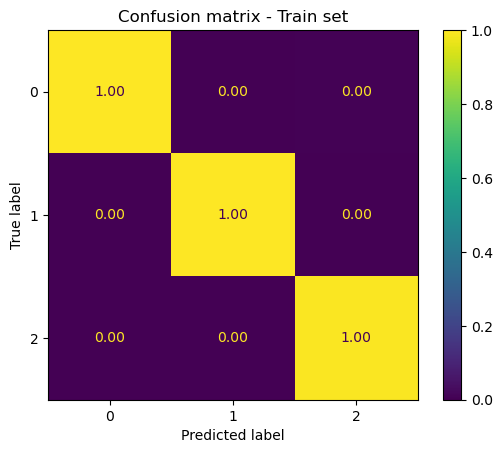

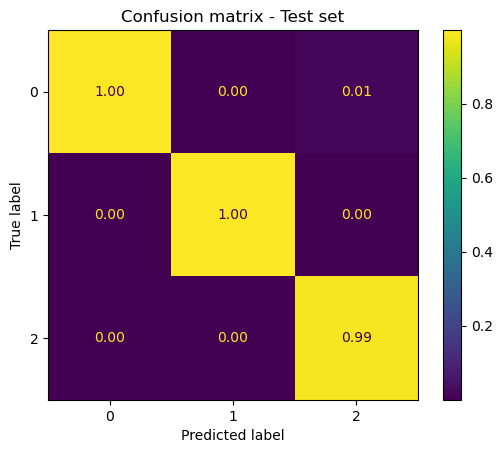

In [210]:
# Transfer the raw data of Gaia into a dataset that can be used by the SVM classifier.

def prepare_dataframe(data):
    df = data

    # The feature uwe that we will use later, contains a division by a - 5, 
    # we need to remove a such that a = 5
    
    df = df[df["astrometric_n_good_obs_al"] > 5]

    # Définir les labels :
    # 0 = star, 1 = galaxy, 2 = quasar
    df = df[(df["galaxy"] > 0.999) | (df["star"] > 0.999) | (df["quasar"] > 0.999)]

    # In Gaia, the stars, galaxies, and quasars are classified in column
    # The values in the column are probabilities
    # We need to retrieve the objects for which we are certain of their nature
    # and also, to assign them a label according to their nature

    def assign_label(row):
        if row["star"] > 0.999:
            return 0
        elif row["galaxy"] > 0.999:
            return 1
        elif row["quasar"] > 0.999:
            return 2
        else:
            return -1

    df["label"] = df.apply(assign_label, axis=1)

    return df

# Feature creation
def create_features(df):
    df = df.copy()

    # sin(b)
    df["sin_b"] = np.sin(np.deg2rad(df["b"]))

    # (uwe)
    df["uwe"] = np.sqrt(df["astrometric_chi2_al"] / (df["astrometric_n_good_obs_al"] - 5))

    # relvarg
    df["relvarg"] = np.sqrt(df["phot_g_n_obs"] / df["phot_g_mean_flux_over_error"])

    features = [
        "sin_b",                  # sine of the Galactic latitude
        "parallax",               # parallax
        "pm",                     # total proper motion
        "uwe",                    # unit weight error (uwe)
        "phot_g_mean_mag",        # G band magnitude
        "bp_g",                   # colour Gbp - G
        "g_rp",                   # colour G - Grp
        "relvarg"                 # The relative variability in the G band (relvarg)
    ]

    X = df[features]
    y = df["label"]
    return X, y

# Load and prepare the data
df = prepare_dataframe(data)
X, y = create_features(df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Hyperparameter optimization using RandomizedSearchCV
param_distributions = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10),
    "svc__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernels
    "svc__degree": [2, 3, 4],  # for the poly kernel
    "svc__coef0": [0, 1]  # for the poly and sigmoid kernels
}

classifier = Pipeline([
    ("scaler", StandardScaler()),  # Scaling
    ("svc", SVC())  # SVM with flexible kernel
])

# Reducing the sample size for quicker hyperparameter search
m = 2500
X_train_sub = X_train.head(m)
y_train_sub = y_train.head(m)

classifier.fit(X_train_sub, y_train_sub)

# Prediction and evaluation over the training set
y_pred_train = classifier.predict(X_train_sub)
print("Train accuracy: ", accuracy_score(y_train_sub, y_pred))
print("Train classification report:\n", classification_report(y_train_sub, y_pred_train))

search = RandomizedSearchCV(classifier, param_distributions, n_iter=10, verbose=2, cv=3, scoring="f1_weighted", n_jobs=2, random_state=42)
search.fit(X_train_sub, y_train_sub)

print("Best hyperparameters:", search.best_estimator_)
print("Best scores:", search.best_score_)

# Test set evaluation
best_model = search.best_estimator_
print("Test accuracy: ", accuracy_score(y_train_sub, y_pred_train))
print("Test classification report:\n", classification_report(y_train_sub, y_pred_train))

disp1 = ConfusionMatrixDisplay.from_predictions(
    y_train_sub, y_pred_train, normalize="pred", values_format=".2f"
)
plt.title("Confusion matrix - Train set")
plt.show()

y_pred_test = best_model.predict(X_test)

disp2 = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test, normalize="pred", values_format=".2f"
)
plt.title("Confusion matrix - Test set")
plt.show()






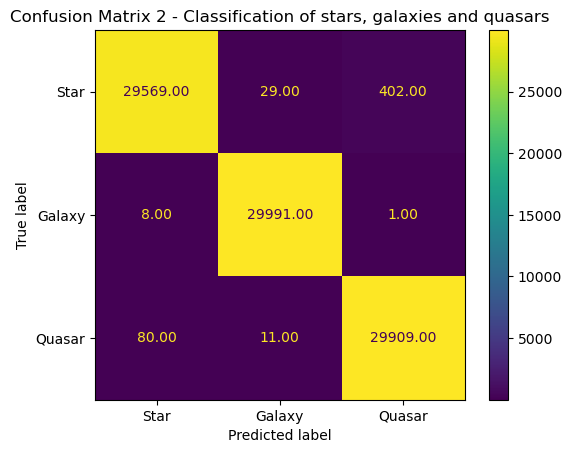

In [211]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

class_names = ['Star', 'Galaxy', 'Quasar']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.viridis, values_format=".2f")

plt.title("Confusion Matrix 2 - Classification of stars, galaxies and quasars")
plt.show()

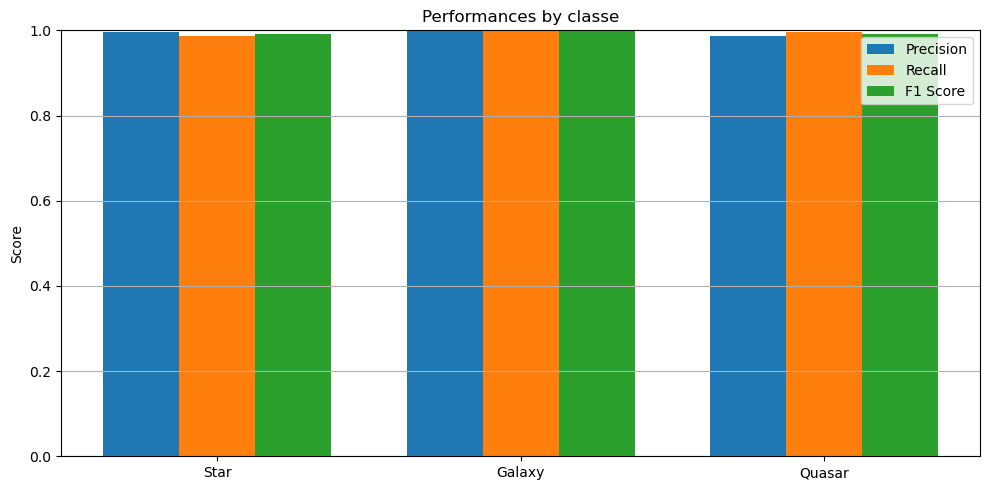

      Class  Precision    Recall  F1 Score
0      Star   0.997033  0.985633  0.991300
1    Galaxy   0.998668  0.999700  0.999184
2    Quasar   0.986705  0.996967  0.991809
3  Accuracy   0.994100  0.994100  0.994100


In [214]:
def plot_metrics(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)

    x = range(len(class_names))

    plt.figure(figsize=(10, 5))
    plt.bar(x, precision, width=0.25, label='Precision', align='center')
    plt.bar([i + 0.25 for i in x], recall, width=0.25, label='Recall', align='center')
    plt.bar([i + 0.5 for i in x], f1, width=0.25, label='F1 Score', align='center')
    plt.xticks([i + 0.25 for i in x], class_names)
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Performances by class')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])

def display_metrics_table(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)

    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    accuracy_row = pd.DataFrame({
        'Class': ['Accuracy'],
        'Precision': [accuracy],
        'Recall': [accuracy],
        'F1 Score': [accuracy]
    })

    metrics_df = pd.concat([metrics_df, accuracy_row], ignore_index=True)
    print(metrics_df)

display_metrics_table(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])


### Importance of features

In [217]:
# if we use kernel = linear

def plot_feature_importances(model, X_train):
    # Check if the model has coefficients (this applies to SVM with a linear kernel)
    if hasattr(model.named_steps['svc'], 'coef_'):
        # Get the coefficients of the model (size [n_classes, n_features])
        coef = model.named_steps['svc'].coef_

        # Calculate the importance of each feature
        feature_importances = np.abs(coef).mean(axis=0)  # Average of absolute coefficients across all classes

        # Feature names
        feature_names = X_train.columns
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        })

        # Sort the features by importance
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.xlabel('Importance')
        plt.title('Feature Importances - SVM')
        plt.show()

        return importance_df
    else:
        print("The model does not have coefficients")
        return None

plot_feature_importances(classifier, X_train)

The model does not have coefficients


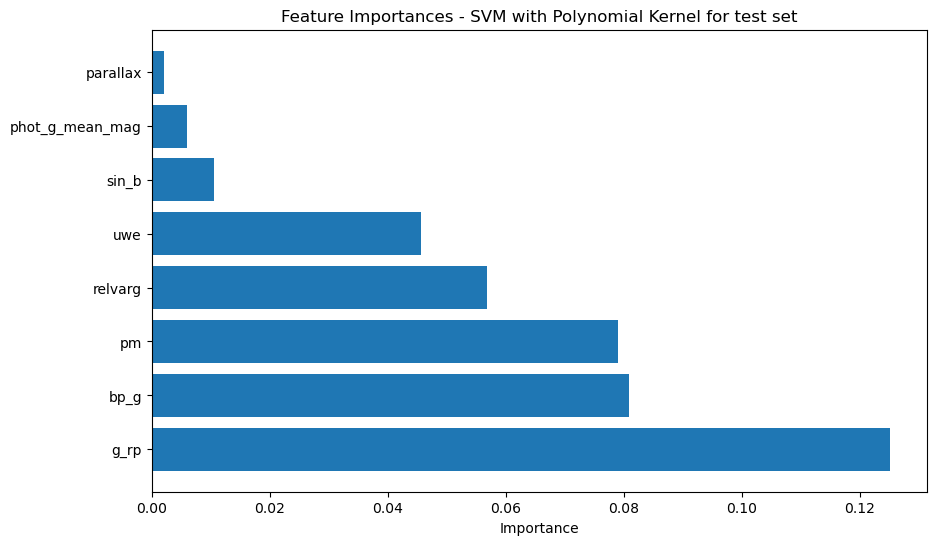

,Feature,Importance
6,g_rp,0.12504
5,bp_g,0.08096
2,pm,0.07896
7,relvarg,0.05676
3,uwe,0.04560
0,sin_b,0.01052
4,phot_g_mean_mag,0.00604
1,parallax,0.00204


In [219]:
def plot_permutation_importances(model, X_train_sub, y_train_sub):
    # Appliquer la permutation importance
    result = permutation_importance(model, X_train_sub, y_train_sub, n_repeats=10, random_state=42)

    # Extraire les importances
    importance_df = pd.DataFrame({
        'Feature': X_train_sub.columns,
        'Importance': result.importances_mean
    })

    # Trier par importance décroissante
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importances - SVM with Polynomial Kernel for test set')
    plt.show()

    return importance_df

plot_permutation_importances(classifier, X_train_sub, y_train_sub)